# Brain Tumor Segmentation
- Inverstigation of BRATS dataset
- Training of SegResNet model
- 26.03.2024
- by gromdimon

## Setup and Imports
First of all you'll need to activate the conda environment and install all the necessary packages. 
Then you can import the libraries and modules that you'll need for the project.

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [1]:
import os
import time
import matplotlib.pyplot as plt

from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.2.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /Users/<username>/.local/share/virtualenvs/brain-segment-cr5a6r00/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.0.post2
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.23.1
scipy version: 1.13.0
Pillow version: 10.3.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.17.2
tqdm version: 4.66.2
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.7.0
transformers version: 4.39.3
mlflow version: 2.11.3
pynrrd version: 1.0.0
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencie

In [2]:
# Add local directories to use them as module
import sys

sys.path.append("../")  # go to parent dir
sys.path.append("../..")

In [3]:
# Set deterministic training for reproducibility
set_determinism(seed=0)

## Data Preparation
The dataset is already prepared and can be accessed via DecathlonDataet class from MONAI library.
Utilize the utility functions to load the data.

In [4]:
from src.utils import load_data, train_transform, val_transform

# Training data
train_loader, train_ds = load_data(train=True)
# Validation data
val_loader, val_ds = load_data(train=False)

Data directory: /Users/gromdimon/Working/brain-segment/src/data
2024-04-12 13:17:09,747 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-04-12 13:17:09,748 - INFO - File exists: /Users/gromdimon/Working/brain-segment/src/data/Task01_BrainTumour.tar, skipped downloading.
2024-04-12 13:17:09,749 - INFO - Non-empty folder exists in /Users/gromdimon/Working/brain-segment/src/data/Task01_BrainTumour, skipped extracting.
Data directory: /Users/gromdimon/Working/brain-segment/src/data
2024-04-12 13:17:21,676 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2024-04-12 13:17:21,677 - INFO - File exists: /Users/gromdimon/Working/brain-segment/src/data/Task01_BrainTumour.tar, skipped downloading.
2024-04-12 13:17:21,678 - INFO - Non-empty folder exists in /Users/gromdimon/Working/brain-segment/src/data/Task01_BrainTumour, skipped extracting.


In [5]:
print(val_ds.__dict__)
print(train_transform)

{'section': 'validation', 'val_frac': 0.2, 'R': RandomState(MT19937) at 0x312BBC840, 'indices': array([ 15, 124, 141, 263, 170, 142, 385, 432, 113,  21, 344, 118, 444,
       327, 250, 225,  75, 102, 310, 355, 472, 100, 245,  37, 391, 319,
       219, 480, 438, 348, 436,  12, 390, 357, 415, 179, 316, 240, 308,
       367,  10,  78, 443, 427, 134,   1, 329, 241, 268, 191, 194, 205,
       317, 132, 239,  96, 236, 351, 352, 309, 459, 474, 318, 405, 196,
       220, 311,  76, 408, 331, 144,  54, 477, 231, 246, 299, 476,  56,
       164,  60, 186,  71, 428,   6,  90, 407, 238, 281,   7, 362,   8,
       418, 419, 107, 466, 188]), '_properties': {'name': 'BRATS', 'description': 'Gliomas segmentation tumour and oedema in on brain images', 'reference': 'https://www.med.upenn.edu/sbia/brats2017.html', 'licence': 'CC-BY-SA 4.0', 'tensorImageSize': '4D', 'modality': {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}, 'labels': {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': '

## Data Analysis
Get the basic information about the dataset: number of samples, classes, shapes of the images and labels.
Visualize the data to understand the structure and the content of the dataset.

image shape: torch.Size([4, 240, 240, 155])


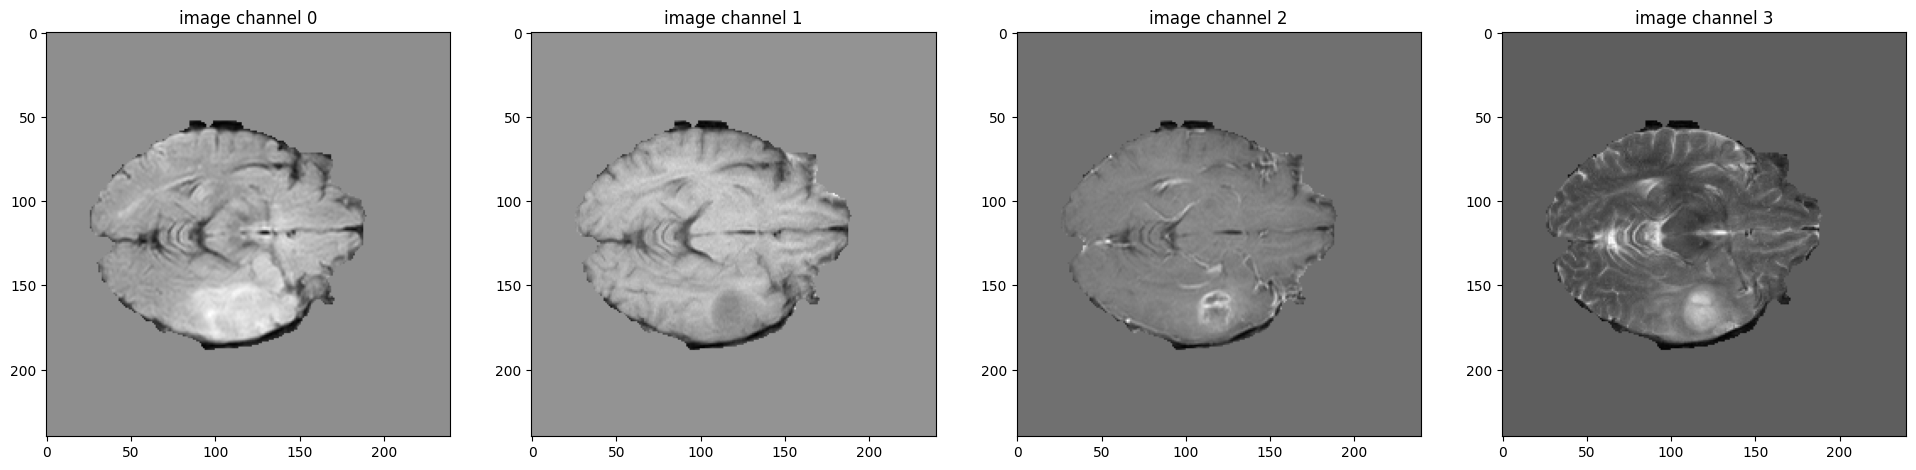

label shape: torch.Size([3, 240, 240, 155])


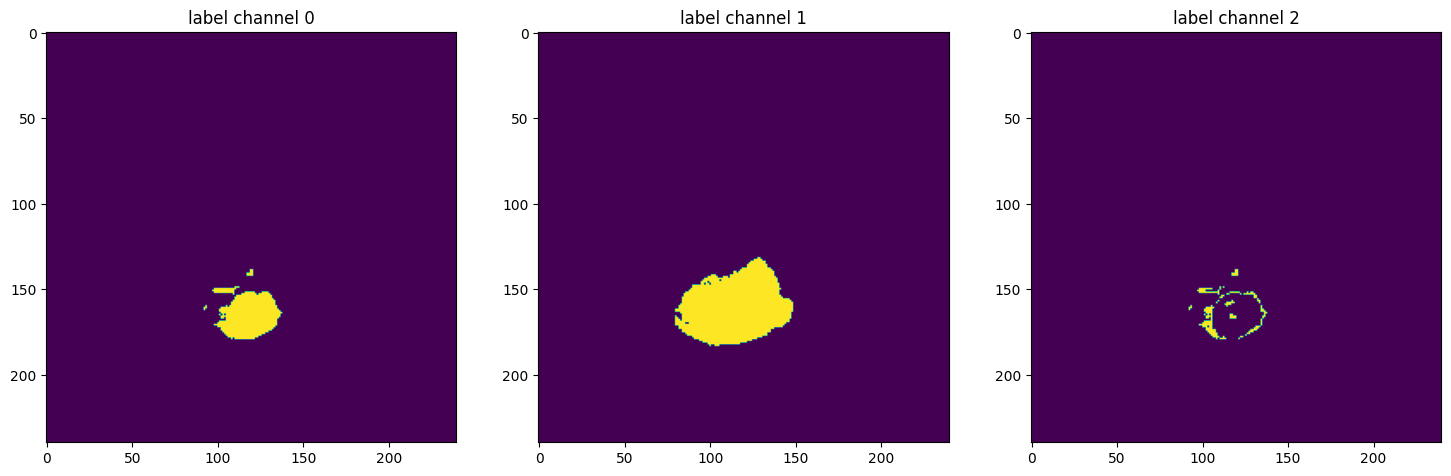

In [6]:
# Check data shape and visualize
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

## Create Model, Loss and Optimizer

In [13]:
max_epochs = 300
val_interval = 1
VAL_AMP = True
device = torch.device("cuda:0") if torch.cuda.device_count() else "cpu"

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimize
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


max_epochs = 300
val_interval = 1
VAL_AMP = True

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


if device == "cuda:0":
    # use amp to accelerate training
    scaler = torch.cuda.amp.GradScaler()
    # enable cuDNN benchmark
    torch.backends.cudnn.benchmark = True

## Training

In [ ]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" tc: {metric_tc:.4f} wt: {metric_wt:.4f} et: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

----------
epoch 1/300


/opt/homebrew/Caskroom/miniforge/base/envs/brain-segm/lib/python3.10/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
Process Process-2:
Process Process-4:
Process Process-1:
Process Process-3:
Traceback (most recent call last):
  File "/opt/homebrew/Caskroom/miniforge/base/envs/brain-segm/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/brain-segm/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/brain-segm/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/homebrew/Caskroom/miniforge/base/envs/brain-segm/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = 